In [2]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split

In [3]:
shuttle_euler_text_file = '/content/drive/MyDrive/CV_FinalProj_Data/close_dist/shuttle_main_closeDist/0.txt'
shuttle_euler_rots_df = pd.read_csv(shuttle_euler_text_file, sep=",", header=None)

In [4]:
shuttle_euler_rots_df = shuttle_euler_rots_df.rename(columns={0: 'x'})
shuttle_euler_rots_df = shuttle_euler_rots_df.rename(columns={1: 'y'})
shuttle_euler_rots_df = shuttle_euler_rots_df.rename(columns={2: 'z'})

In [5]:
shuttle_euler_rots_df = (shuttle_euler_rots_df - 180.0)/180.0

In [6]:
shuttle_euler_rots_df['img name'] = ""
# create annotations file:
for i in range(0,20001):
  shuttle_euler_rots_df.loc[i, 'img name'] = "sequence." + str(i) + "/" + "step0.camera.png"

In [7]:
shuttle_euler_rots_df = shuttle_euler_rots_df.reindex(columns=['img name', 'x', 'y', 'z'])

In [8]:
shuttle_euler_rots_df.tail(5)

,img name,x,y,z
19996,sequence.19996/step0.camera.png,-0.711986,-0.290344,-1.0
19997,sequence.19997/step0.camera.png,-0.652041,0.259622,-1.0
19998,sequence.19998/step0.camera.png,-0.803894,-0.423482,-1.0
19999,sequence.19999/step0.camera.png,-0.854223,0.974591,-1.0
20000,sequence.20000/step0.camera.png,-0.737619,0.796913,-1.0


In [18]:



# Define the custom model
class ResNetRotationModel(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNetRotationModel, self).__init__()
        # Load a pre-trained ResNet model
        self.backbone = models.resnet18(pretrained=pretrained)
        num_features = self.backbone.fc.in_features
        # Replace the fully connected layer with a custom head for regression
        self.backbone.fc = nn.Linear(num_features, 3)  # Output x, y, z rotations

    def forward(self, x):
        return self.backbone(x)

# Define a custom dataset
class RotationDataset(Dataset):
    def __init__(self, image_dir, annotations, transform=None):
        self.image_dir = image_dir
        self.annotations = annotations
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if isinstance(idx, torch.Tensor):
            idx = idx.item()

        # Load image
        img_name = os.path.join(self.image_dir, str(self.annotations.iloc[idx, 0]))
        image = Image.open(img_name).convert("RGB")

        # Load rotation labels (x, y, z)
        rotation_labels = self.annotations.iloc[idx, 1:4].values.astype('float')
        rotation_labels = torch.tensor(rotation_labels, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, rotation_labels

# Paths
images = '/content/drive/MyDrive/CV_FinalProj_Data/close_dist/shuttle_main_closeDist/solo/'
annotations_file = shuttle_euler_rots_df

# Define transformations for images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard normalization for ResNet
])

# Split data
train_annotations, test_annotations = train_test_split(annotations_file, test_size=0.2, random_state=42)


train_dataset = RotationDataset(image_dir=images, annotations=train_annotations, transform=transform)
test_dataset = RotationDataset(image_dir=images, annotations=test_annotations, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = ResNetRotationModel(pretrained=True).to(device)



criterion = nn.MSELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [21]:
for param in model.backbone.parameters():
    param.requires_grad = False

for param in model.backbone.fc.parameters():
    param.requires_grad = True

for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

backbone.conv1.weight: requires_grad=False
backbone.bn1.weight: requires_grad=False
backbone.bn1.bias: requires_grad=False
backbone.layer1.0.conv1.weight: requires_grad=False
backbone.layer1.0.bn1.weight: requires_grad=False
backbone.layer1.0.bn1.bias: requires_grad=False
backbone.layer1.0.conv2.weight: requires_grad=False
backbone.layer1.0.bn2.weight: requires_grad=False
backbone.layer1.0.bn2.bias: requires_grad=False
backbone.layer1.1.conv1.weight: requires_grad=False
backbone.layer1.1.bn1.weight: requires_grad=False
backbone.layer1.1.bn1.bias: requires_grad=False
backbone.layer1.1.conv2.weight: requires_grad=False
backbone.layer1.1.bn2.weight: requires_grad=False
backbone.layer1.1.bn2.bias: requires_grad=False
backbone.layer2.0.conv1.weight: requires_grad=False
backbone.layer2.0.bn1.weight: requires_grad=False
backbone.layer2.0.bn1.bias: requires_grad=False
backbone.layer2.0.conv2.weight: requires_grad=False
backbone.layer2.0.bn2.weight: requires_grad=False
backbone.layer2.0.bn2.bia

In [22]:
from tqdm import tqdm

training_losses = []
testing_losses = []

num_epochs = 15
for epoch in range(num_epochs):
  model.train()
  for images, rotation_labels in tqdm(train_loader, desc=f' Training epoch{epoch + 1}/{num_epochs}', dynamic_ncols=True):
      images, rotation_labels = images.to(device), rotation_labels.to(device)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, rotation_labels)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      optimizer.step()

  # Evaluation
  model.eval()
  test_loss = 0
  with torch.no_grad():
      for test_images, test_rotation_labels in tqdm(test_loader, desc=f' Eval epoch{epoch + 1}/{num_epochs}', dynamic_ncols=True):
          test_images, test_rotation_labels = test_images.to(device), test_rotation_labels.to(device)
          test_outputs = model(test_images)
          test_loss += criterion(test_outputs, test_rotation_labels).item()

  training_losses.append(loss.item())
  testing_losses.append(test_loss / len(test_loader))
  print(f"Epoch {epoch + 1}, Loss: {loss.item()}, Test Loss: {test_loss / len(test_loader)}")

  # save model state
  torch.save(model.state_dict(), '/content/drive/MyDrive/rotation_resnet18_frozen.pth')

 Eval epoch1/15: 100%|██████████| 126/126 [22:14<00:00, 10.59s/it]


Epoch 1, Loss: 0.06206341087818146, Test Loss: 0.06273581616817013


 Eval epoch2/15: 100%|██████████| 126/126 [00:44<00:00,  2.85it/s]


Epoch 2, Loss: 0.07378200441598892, Test Loss: 0.054676767276038256


 Eval epoch3/15: 100%|██████████| 126/126 [00:43<00:00,  2.88it/s]


Epoch 3, Loss: 0.03667479008436203, Test Loss: 0.0677554198422484


 Eval epoch4/15: 100%|██████████| 126/126 [00:43<00:00,  2.88it/s]


Epoch 4, Loss: 0.05422059819102287, Test Loss: 0.051716147655887265


 Eval epoch5/15: 100%|██████████| 126/126 [00:44<00:00,  2.86it/s]


Epoch 5, Loss: 0.05593708157539368, Test Loss: 0.05986509736745604


 Eval epoch6/15: 100%|██████████| 126/126 [00:43<00:00,  2.88it/s]


Epoch 6, Loss: 0.06588597595691681, Test Loss: 0.0521926363516185


 Eval epoch7/15: 100%|██████████| 126/126 [00:43<00:00,  2.89it/s]


Epoch 7, Loss: 0.05491725727915764, Test Loss: 0.059605848493187556


 Eval epoch8/15: 100%|██████████| 126/126 [00:43<00:00,  2.89it/s]


Epoch 8, Loss: 0.03540309891104698, Test Loss: 0.05388836197495934


 Eval epoch9/15: 100%|██████████| 126/126 [00:44<00:00,  2.85it/s]


Epoch 9, Loss: 0.07278446853160858, Test Loss: 0.056706164874846025


 Eval epoch10/15: 100%|██████████| 126/126 [00:44<00:00,  2.86it/s]


Epoch 10, Loss: 0.047660212963819504, Test Loss: 0.0632773180832229


 Eval epoch11/15: 100%|██████████| 126/126 [00:43<00:00,  2.89it/s]


Epoch 11, Loss: 0.020974203944206238, Test Loss: 0.05929468258742302


 Eval epoch12/15: 100%|██████████| 126/126 [00:43<00:00,  2.90it/s]


Epoch 12, Loss: 0.04193302243947983, Test Loss: 0.05637170786836317


 Eval epoch13/15: 100%|██████████| 126/126 [00:44<00:00,  2.84it/s]


Epoch 13, Loss: 0.03880421817302704, Test Loss: 0.05110829261442026


 Eval epoch14/15: 100%|██████████| 126/126 [00:44<00:00,  2.85it/s]


Epoch 14, Loss: 0.0571146123111248, Test Loss: 0.0639623859601598


 Eval epoch15/15: 100%|██████████| 126/126 [00:43<00:00,  2.87it/s]

Epoch 15, Loss: 0.077629454433918, Test Loss: 0.055359684862196445


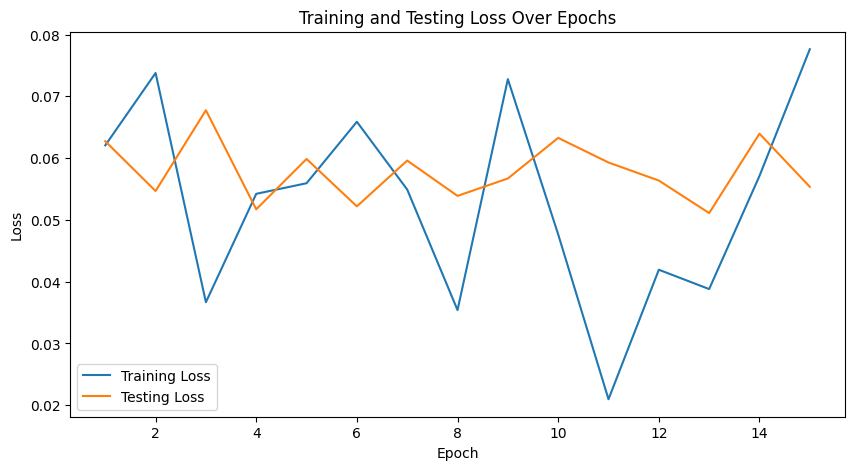

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), testing_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.show()

In [24]:
for param in model.backbone.parameters():
    param.requires_grad = True

for param in model.backbone.fc.parameters():
    param.requires_grad = True

for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

backbone.conv1.weight: requires_grad=True
backbone.bn1.weight: requires_grad=True
backbone.bn1.bias: requires_grad=True
backbone.layer1.0.conv1.weight: requires_grad=True
backbone.layer1.0.bn1.weight: requires_grad=True
backbone.layer1.0.bn1.bias: requires_grad=True
backbone.layer1.0.conv2.weight: requires_grad=True
backbone.layer1.0.bn2.weight: requires_grad=True
backbone.layer1.0.bn2.bias: requires_grad=True
backbone.layer1.1.conv1.weight: requires_grad=True
backbone.layer1.1.bn1.weight: requires_grad=True
backbone.layer1.1.bn1.bias: requires_grad=True
backbone.layer1.1.conv2.weight: requires_grad=True
backbone.layer1.1.bn2.weight: requires_grad=True
backbone.layer1.1.bn2.bias: requires_grad=True
backbone.layer2.0.conv1.weight: requires_grad=True
backbone.layer2.0.bn1.weight: requires_grad=True
backbone.layer2.0.bn1.bias: requires_grad=True
backbone.layer2.0.conv2.weight: requires_grad=True
backbone.layer2.0.bn2.weight: requires_grad=True
backbone.layer2.0.bn2.bias: requires_grad=Tru

In [25]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

 Eval epoch1/7: 100%|██████████| 126/126 [00:44<00:00,  2.84it/s]


Epoch 1, Loss: 0.009028258733451366, Test Loss: 0.006281191843473131


 Eval epoch2/7: 100%|██████████| 126/126 [00:44<00:00,  2.82it/s]


Epoch 2, Loss: 0.0028135343454778194, Test Loss: 0.005551103483109425


 Eval epoch3/7: 100%|██████████| 126/126 [00:44<00:00,  2.83it/s]


Epoch 3, Loss: 0.000794180843513459, Test Loss: 0.002481569062862065


 Eval epoch4/7: 100%|██████████| 126/126 [00:44<00:00,  2.85it/s]


Epoch 4, Loss: 0.0014918951783329248, Test Loss: 0.003487230819975218


 Eval epoch5/7: 100%|██████████| 126/126 [00:44<00:00,  2.85it/s]


Epoch 5, Loss: 0.0008709902758710086, Test Loss: 0.0021723307988380956


 Eval epoch6/7: 100%|██████████| 126/126 [00:44<00:00,  2.85it/s]


Epoch 6, Loss: 0.0007959583308547735, Test Loss: 0.003282557210204975


 Eval epoch7/7: 100%|██████████| 126/126 [00:44<00:00,  2.84it/s]


Epoch 7, Loss: 0.00018884055316448212, Test Loss: 0.0018437218432876443


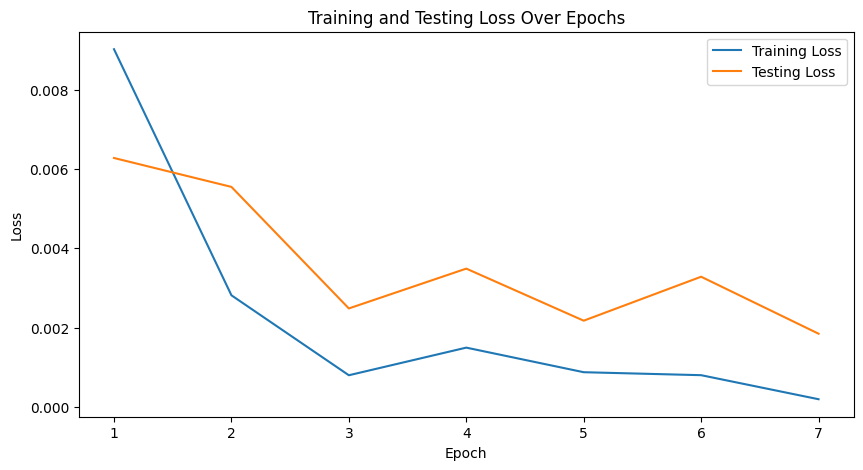

In [26]:
from tqdm import tqdm

training_losses = []
testing_losses = []

num_epochs = 7
for epoch in range(num_epochs):
  model.train()
  for images, rotation_labels in tqdm(train_loader, desc=f' Training epoch{epoch + 1}/{num_epochs}', dynamic_ncols=True):
      images, rotation_labels = images.to(device), rotation_labels.to(device)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, rotation_labels)
      loss.backward()
      optimizer.step()

  # Evaluation
  model.eval()
  test_loss = 0
  with torch.no_grad():
      for test_images, test_rotation_labels in tqdm(test_loader, desc=f' Eval epoch{epoch + 1}/{num_epochs}', dynamic_ncols=True):
          test_images, test_rotation_labels = test_images.to(device), test_rotation_labels.to(device)
          test_outputs = model(test_images)
          test_loss += criterion(test_outputs, test_rotation_labels).item()

  training_losses.append(loss.item())
  testing_losses.append(test_loss / len(test_loader))
  print(f"Epoch {epoch + 1}, Loss: {loss.item()}, Test Loss: {test_loss / len(test_loader)}")
  torch.save(model.state_dict(), '/content/drive/MyDrive/rotation_resnet18_fine_tuned.pth')

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), testing_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.show()




In [27]:
predictions = []
model.eval()
with torch.no_grad():
    for test_images, test_rotation_labels in tqdm(test_loader):
        test_images = test_images.to(device)
        test_outputs = model(test_images)
        predictions.extend(test_outputs.cpu().numpy())

100%|██████████| 126/126 [00:44<00:00,  2.85it/s]


In [29]:
import numpy as np

predictions_array = np.array(predictions)
orig = []

for val in test_annotations.iloc[:, 1:4].values:
  orig.append(val)

orig_array = np.array(orig)

predictions_degrees = predictions_array * 180.0
orig_degrees = orig_array * 180.0

differences = orig_degrees - predictions_degrees
differences = np.abs(differences)

differences_df = pd.DataFrame(differences, columns=['x', 'y', 'z'])

x_avg = differences_df['x'].mean()
y_avg = differences_df['y'].mean()
z_avg = differences_df['z'].mean()

print(f"Average difference in x: {x_avg}")
print(f"Average difference in y: {y_avg}")
print(f"Average difference in z: {z_avg}")

differences_df.head(10)

Average difference in x: 1.380972990449897
Average difference in y: 4.266019202590543
Average difference in z: 0.6891635117465751


,x,y,z
0,0.008667,2.891915,0.465530
1,1.061070,7.745391,0.639069
2,0.414993,6.459447,1.439301
3,3.135321,2.550882,0.982224
4,0.428935,0.112833,1.457703
5,0.973552,0.803027,0.864960
6,0.709681,1.168736,0.519775
7,3.407221,0.995051,0.119415
8,0.601246,7.312666,0.571823
9,2.047130,3.236164,1.530792
